In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import numpy as np
import random

Chargmenet est exploitation des données

In [2]:
data = loadmat('ecg_dataset.mat')
print(data.keys())
X = data['X']
Y = data['y'].flatten()
classe, count = np.unique(Y,return_counts=True)
for c, n in zip(classe, count):
    print(f"Classe {c} : {n} échantillons")

data

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Classe 0 : 5288 échantillons
Classe 1 : 111 échantillons
Classe 2 : 6 échantillons


{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Aug 26 17:46:48 2025',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[-0.61 , -0.61 , -0.595, ..., -0.83 , -0.81 , -0.81 ],
        [-0.355, -0.375, -0.365, ...,  0.   ,  0.   ,  0.   ],
        [-0.26 , -0.26 , -0.25 , ...,  0.   ,  0.   ,  0.   ],
        ...,
        [-0.23 , -0.235, -0.2  , ...,  0.   ,  0.   ,  0.   ],
        [ 0.15 ,  0.185,  0.195, ...,  0.   ,  0.   ,  0.   ],
        [-0.24 , -0.24 , -0.23 , ...,  0.   ,  0.   ,  0.   ]]),
 'y': array([[0],
        [0],
        [1],
        ...,
        [0],
        [0],
        [0]], dtype=uint8)}

index = 0
index = 2
index = 1148


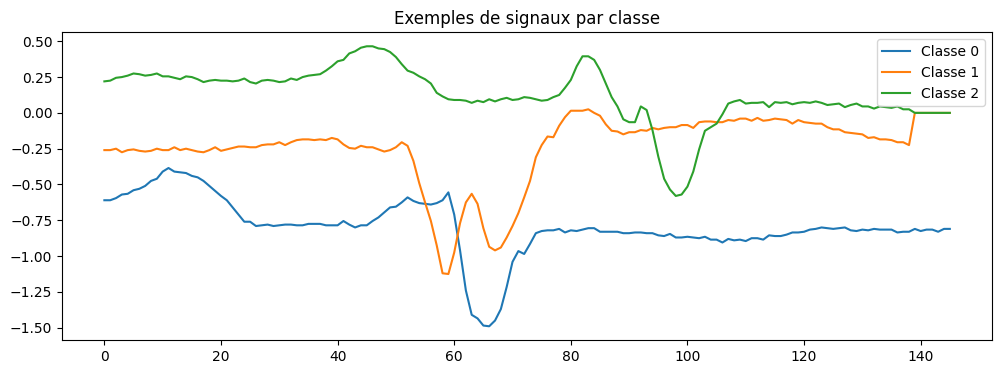

In [3]:
plt.figure(figsize=(12,4))
for c in [0, 1, 2]:
    idx = np.where(Y == c)[0][0] 
    print(f'index = {idx}')
    plt.plot(X[idx], label=f'Classe {c}')
plt.legend()
plt.title("Exemples de signaux par classe")
plt.show()

Prétraitement, centrage et mise à l’échelle des signaux

In [4]:
X_norm =(X- X.mean(axis=1, keepdims=True))/(X.std(axis=1, keepdims=True)+1e-8)
X_norm

array([[ 0.93153123,  0.93153123,  1.00821055, ..., -0.19309884,
        -0.09085975, -0.09085975],
       [ 0.23055808,  0.13724836,  0.18390322, ...,  1.88680549,
         1.88680549,  1.88680549],
       [-0.08324134, -0.08324134, -0.04218311, ...,  0.98427256,
         0.98427256,  0.98427256],
       ...,
       [ 0.11195021,  0.08362312,  0.28191276, ...,  1.41499637,
         1.41499637,  1.41499637],
       [ 0.25212855,  0.39560037,  0.43659231, ..., -0.36275065,
        -0.36275065, -0.36275065],
       [ 0.24736046,  0.24736046,  0.30039222, ...,  1.52012264,
         1.52012264,  1.52012264]])

Recuperatioin de la classe d'entrainement classe N(0)
préparation des ensembles de données nécessaires à l’entraînement et à l’évaluation du modèle.
les signaux normaux pour l’apprentissage, et les deux types d’anomalies pour les tests.

In [5]:
X_normal = X_norm[Y==0][:, :144]
X_anomaly_R = X_norm[Y==1][:, :144]
X_anomaly_V = X_norm[Y==2][:, :144]


ensembles d’apprentissage et de test en leur donnant la bonne forme 
pour être acceptés par le réseau de neurones convolutif

In [6]:
X_training, X_validation = train_test_split(X_normal, test_size=0.2, random_state=42)
X_training = X_training[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_anomaly_R = X_anomaly_R[..., np.newaxis]
X_anomaly_V = X_anomaly_V[..., np.newaxis]
X_normal = X_normal[...,np.newaxis]

architecture du modèle autoencodeur
prend un signal ECG, le compresse avec l’encodeur, puis le reconstruit avec le decodeur.


In [7]:
data_input =(144, 1)
encoder = models.Sequential([
    layers.Input(shape=data_input),
    layers.Conv1D(8, kernel_size=7, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(16, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(16, activation='relu')  
])

decoder = models.Sequential([
    layers.Dense((144 // 4) * 32, activation='relu'),
    layers.Reshape((144 // 4, 32)),
    layers.UpSampling1D(size=2),
    layers.Conv1DTranspose(16, kernel_size=5, activation='relu', padding='same'),
    layers.UpSampling1D(size=2),
    layers.Conv1DTranspose(8, kernel_size=7, activation='relu', padding='same'),
    layers.Conv1D(1, kernel_size=1, activation='linear', padding='same')
])

input_autoencodeur = layers.Input(shape = data_input)
data_encoded= encoder(input_autoencodeur)
data_decoded = decoder(data_encoded)

autoencodeur = models.Model(input_autoencodeur, data_decoded)

# compilation de l'autoencodeur

In [8]:
autoencodeur.compile(optimizer='adam', loss = 'mse')

#entrainement du models

In [9]:
training_history = autoencodeur.fit(
    X_training, X_training, epochs=50, batch_size=32,
    validation_data=(X_validation, X_validation),
    shuffle=True)

Epoch 1/50
133/133 [==============================] - 9s 32ms/step - loss: 0.2130 - val_loss: 0.0427
Epoch 2/50
133/133 [==============================] - 3s 23ms/step - loss: 0.0306 - val_loss: 0.0247
Epoch 3/50
133/133 [==============================] - 3s 24ms/step - loss: 0.0228 - val_loss: 0.0204
Epoch 4/50
133/133 [==============================] - 3s 24ms/step - loss: 0.0187 - val_loss: 0.0171
Epoch 5/50
133/133 [==============================] - 3s 23ms/step - loss: 0.0162 - val_loss: 0.0156
Epoch 6/50
133/133 [==============================] - 3s 24ms/step - loss: 0.0146 - val_loss: 0.0146
Epoch 7/50
133/133 [==============================] - 3s 23ms/step - loss: 0.0136 - val_loss: 0.0140
Epoch 8/50
133/133 [==============================] - 4s 27ms/step - loss: 0.0127 - val_loss: 0.0131
Epoch 9/50
133/133 [==============================] - 4s 27ms/step - loss: 0.0123 - val_loss: 0.0126
Epoch 10/50
133/133 [==============================] - 4s 28ms/step - loss: 0.0117 - val_lo

# calcul du scroe d'anomalie(mse)

In [10]:
def anomaly_score(model, data):
    reconstructon = model.predict(data)
    errors = np.mean((data - reconstructon)**2, axis=(1,2))
    return errors

error_N = anomaly_score(autoencodeur, X_training)
error_R = anomaly_score(autoencodeur, X_anomaly_R)
error_V = anomaly_score(autoencodeur, X_anomaly_V)

print("============ Scroe d'anomalie =============")
print(f'Normales: {error_N}')
print(f'Anomalie R: {error_R}')
print(f'Anomalie V: {error_V}')

1/1 [==============================] - 0s 51ms/step
============ Scroe d'anomalie =============
Normales: [0.00485474 0.00326794 0.00577385 ... 0.00381091 0.00260416 0.00592501]
Anomalie R: [0.18746326 0.21786279 0.19180528 0.20562043 0.15262744 0.20842322
 0.16664245 0.21045909 0.20000682 0.20480959 0.24415946 0.24686931
 0.30818144 0.22411374 0.18366091 0.31534234 0.24214128 0.3200123
 0.21252018 0.2382293  0.31575764 0.15937349 0.26092647 0.20339506
 0.17974248 0.20521244 0.22016118 0.25643925 0.27123568 0.22914604
 0.13399177 0.20759277 0.18393749 0.23081885 0.21144481 0.71496202
 0.22604146 0.19235887 0.23092364 0.2503809  0.2518793  0.31231966
 0.16634352 0.2037199  0.23217686 0.23990697 0.2176373  0.21563251
 0.22413753 0.18301363 0.20365806 0.19829975 0.28648472 0.22563655
 0.18427091 0.15915135 0.18836539 0.17660571 0.18439241 0.18603685
 0.2143521  0.300174   0.24676468 0.32882647 0.23458718 0.14674269
 0.24013926 0.10709937 0.17409225 0.15093865 0.12701312 0.30016911
 0.1717

# Dertermination du seuil

In [11]:
seuil = np.percentile(error_N, 99)
print('========== Seuil de detection =============')
print(f'99eme percentil sur les données normales: {seuil:.6f}')


========== Seuil de detection =============
99eme percentil sur les données normales: 0.041923


In [12]:
def detect_anomaly(model,x,seuil):
    reconst = model.predict(x)
    error = np.mean((x-reconst)**2)
    return f"Normale, Erreur = {error:.4}" if error < seuil else f"Anomalie detectée, Erreur = {error:.4f}"

In [13]:
print("Erreurs max :")
print("  Normaux :", np.max(error_N))
print("  Anomalies R :", np.max(error_R))
print("  Anomalies V :", np.max(error_V))


Erreurs max :
  Normaux : 0.4768098858161463
  Anomalies R : 0.7149620181314263
  Anomalies V : 0.5069206919763624


Visualition des score d'erreur

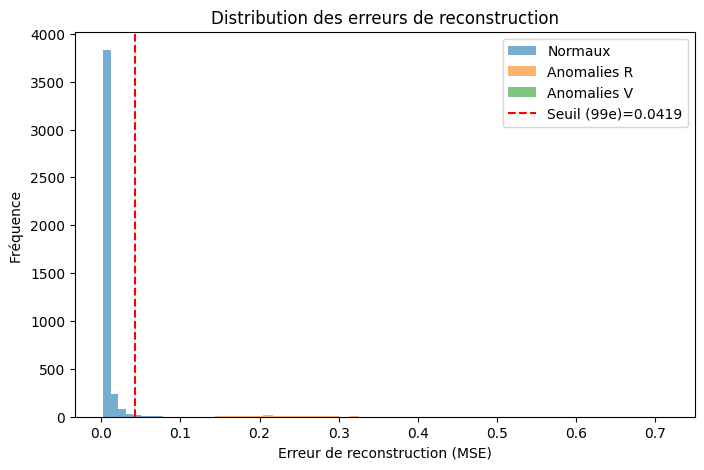

In [23]:
plt.figure(figsize=(8,5))
plt.hist(error_N, bins=50, alpha=0.6, label='Normaux')
plt.hist(error_R, bins=50, alpha=0.6, label='Anomalies R')
plt.hist(error_V, bins=50, alpha=0.6, label='Anomalies V')
plt.axvline(seuil, color='red', linestyle='--', label=f'Seuil (99e)={seuil:.4f}')
#plt.yscale('log')  
plt.xlabel("Erreur de reconstruction (MSE)")
plt.ylabel("Fréquence ")
plt.title("Distribution des erreurs de reconstruction")
plt.legend()
plt.show()



1/1 [==============================] - 0s 49ms/step


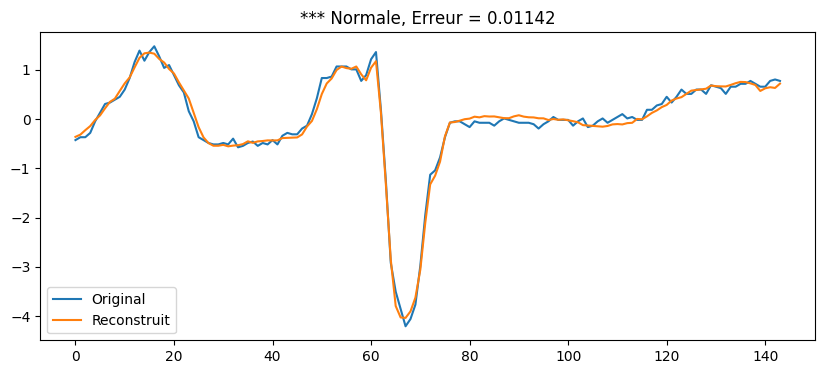

1/1 [==============================] - 0s 48ms/step


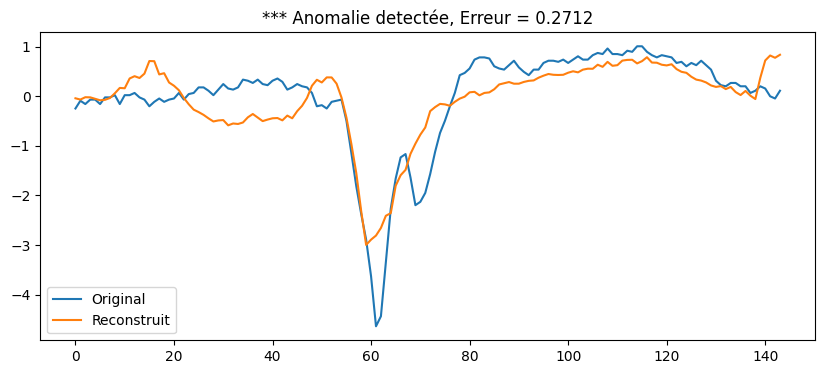

1/1 [==============================] - 0s 40ms/step


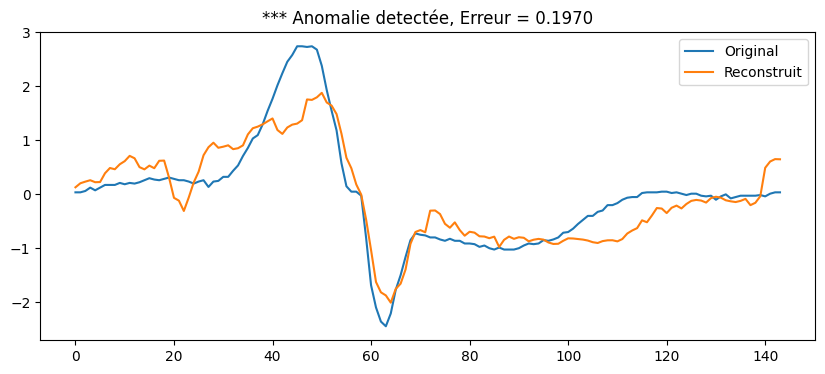

In [15]:
def visualization(signals):
    i = random.randint(0,len(signals)-1)
    original = signals[i].squeeze()
    signal = np.array(signals[i]).reshape(1, 144, 1)
    reconst = autoencodeur.predict(signal, verbose=0)[0].squeeze()
    plt.figure(figsize=(10,4))
    plt.plot(original, label="Original")
    plt.plot(reconst, label="Reconstruit", linestyle="-")
    plt.title(f"*** {detect_anomaly(autoencodeur,signal,seuil)}")
    plt.legend()
    plt.show()

visualization(X_normal)
visualization(X_anomaly_R)
visualization(X_anomaly_V)

#Evaluation des performance du models

In [16]:
det_N = np.sum(error_N > seuil)
det_R = np.sum(error_R > seuil)
det_V = np.sum(error_V > seuil)
print("Seuil (99e) =", seuil)
print(f"FP (normaux>seuil): {det_N}/{len(error_N)}")
print(f"R détectées: {det_R}/{len(error_R)}")
print(f"V détectées: {det_V}/{len(error_V)}")


Seuil (99e) = 0.04192289411174583
FP (normaux>seuil): 43/4230
R détectées: 111/111
V détectées: 6/6


In [17]:
all_errors= np.concatenate([error_N, error_R, error_V])
all_labels = np.concatenate([
    np.zeros_like(error_N),   
    np.ones_like(error_R),    
    np.ones_like(error_V)     
])
preds_all = (all_errors > seuil).astype(int)

In [18]:
print(classification_report(all_labels, preds_all, target_names=["Normal", "Anomalie"]))

# Matrice de confusion
cm = confusion_matrix(all_labels, preds_all)
print("Matrice de confusion :\n", cm)

# Aire sous la courbe ROC
auc_area = roc_auc_score(all_labels, all_errors)
print(f"AUC ROC : {auc_area:.4f}")


              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99      4230
    Anomalie       0.73      1.00      0.84       117

    accuracy                           0.99      4347
   macro avg       0.87      0.99      0.92      4347
weighted avg       0.99      0.99      0.99      4347

Matrice de confusion :
 [[4187   43]
 [   0  117]]
AUC ROC : 0.9997


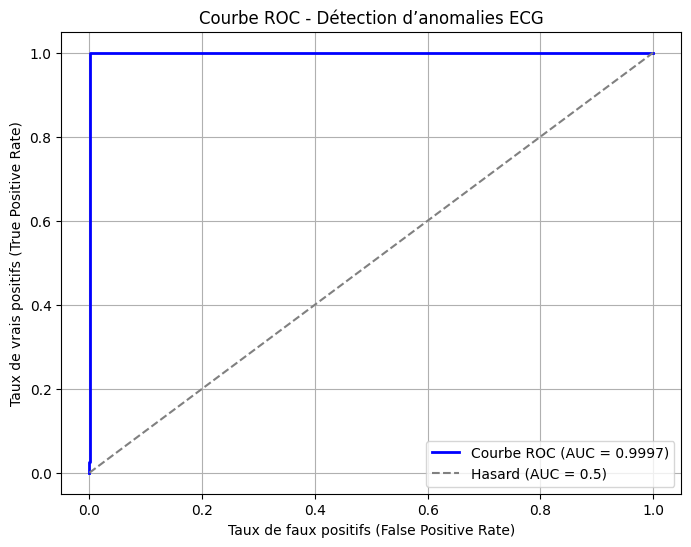

In [19]:
fpr, tpr, thresholds = roc_curve(all_labels, all_errors)
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Hasard (AUC = 0.5)')
plt.xlabel('Taux de faux positifs (False Positive Rate)')
plt.ylabel('Taux de vrais positifs (True Positive Rate)')
plt.title('Courbe ROC - Détection d’anomalies ECG')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()